#functions and libraries

In [ ]:
import pandas as pd
import numpy as np
import yellowbrick
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score , precision_score , recall_score , roc_auc_score , confusion_matrix , f1_score
from sklearn.svm import SVC ,LinearSVC
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(21, 19), dpi=80)
plt.rc('font', size=20)
plt.rc('axes', titlesize=24)    
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)   
plt.rc('ytick', labelsize=24)  
plt.rc('legend', fontsize=20) 
plt.rc('figure', titlesize=20)
plt.rcParams["figure.figsize"] = (19,15)
plt.rcParams["font.family"] = "Times New Roman"
#in case to  return things to their previous size un-comment bellow and comment above
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
import datetime
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
from yellowbrick.target import FeatureCorrelation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression


def set_tags_no2(labels):
  templ=np.array(labels,dtype='object')
  for i in range(len(labels)):
    if labels[i]>200:
      templ[i]='Very unhealthy'
    elif labels[i]<=200 and labels[i]>150:
      templ[i]='Unhealthy'
    elif labels[i]<=150 and labels[i]>100:
      templ[i]='Unhealthy for sensitive group'
    elif labels[i]<=100 and labels[i]>50:
      templ[i]='Moderate'
    else:
      templ[i]='Good'
  return templ

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score 

def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance

def permutation_importance(model, X, y, n_repeats=10):
    """Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

def plot_importantes_features(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots(figsize=(10,20))

    indices = perm_importance_result['importances_mean'].argsort()
    y=perm_importance_result['importances_mean'][indices]
    plt.barh(range(len(indices)),
             y,
             xerr=perm_importance_result['importances_std'][indices],color='blue')

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])
    for i, v in enumerate(y):
      ax.text(0, i, str(round(v, 2)), color='black', fontweight='bold')
    plt.legend()

def correlation(ino,oto):
  X, y = ino, oto

  # Create a list of the feature names
  features = np.array(X.columns.tolist())

  # Instantiate the visualizer
  visualizer = FeatureCorrelation(labels=features)

  visualizer.fit(X, y)        # Fit the data to the visualizer
  visualizer.show()    

def confplt(classifier,X_test,y_test,class_names):
  titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    olaf=""
    if str(type(classifier).__name__)=="LGBMClassifier":
      olaf="LGBM Classifier"
    elif str(type(classifier).__name__)=="DecisionTreeClassifier":
      olaf="Decision Tree Classifier"
    elif str(type(classifier).__name__)=="KNeighborsClassifier":
      olaf="KNeighbors Classifier"
    else:
      olaf="Boosting Regression Tree Classifier"
    disp.ax_.set_title(title+" for "+olaf)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)



<Figure size 1680x1520 with 0 Axes>

In [ ]:
# from google.colab import files
# uploaded = files.upload()

#data processing

In [ ]:
DF2018=pd.read_csv('mix2018.csv')
DF2018.reset_index(drop=True, inplace=True)

tf=DF2018['Traffic Flow'].values
twmv=np.round(tf* 0.0063)
cat=np.round(tf*0.8)
bac=np.round(tf*0.0124)
lgvs=np.round(tf*0.1813)
DF2018['two wheeled motor vehicles']=twmv
DF2018['cars and taxis']=cat
DF2018['buses and coaches']=bac
DF2018['lgvs']=lgvs

In [ ]:
labels2018=DF2018['NO2']
templ2018=set_tags_no2(labels2018)
DF2018.NO2=templ2018
trainx18,testx18,trainy18,testy18=tts(DF2018.drop('NO2', axis=1),DF2018['NO2'],test_size=0.30,random_state=300)

#classifiers

lightbeam

In [ ]:
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  

from lightgbm import LGBMClassifier
log18 = LGBMClassifier().fit(Xs_of_train, Ys_of_train)


log18_train_res = log18.predict(Xs_of_train)
com_acc_train = accuracy_score(log18_train_res, Ys_of_train)

print(f'Training accuracy : {com_acc_train*100}%')



Training accuracy : 100.0%


In [ ]:

Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
DT18 = DecisionTreeClassifier(max_depth=10, random_state=1234)
DT18.fit(Xs_of_train, Ys_of_train)

DT18_train_res = DT18.predict(Xs_of_train)
dtacc_trainc = accuracy_score(DT18_train_res, Ys_of_train)

print(f'Training accuracy : {dtacc_trainc*100}%')


Training accuracy : 98.20359281437125%


In [ ]:
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

KN18=KNeighborsClassifier(n_neighbors=5)  
KN18.fit(Xs_of_train, Ys_of_train)

KN18_train_res = KN18.predict(Xs_of_train)
knacc_trainc = accuracy_score(KN18_train_res, Ys_of_train)
print(f'Training accuracy : {knacc_trainc*100}%')

Training accuracy : 86.65526090675792%


In [ ]:
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4
  
BRT18 = GradientBoostingClassifier(max_depth=10, random_state=1234)
BRT18.fit(Xs_of_train, Ys_of_train)

BRT18_train_res = BRT18.predict(Xs_of_train)
brtacc_trainc = accuracy_score(BRT18_train_res, Ys_of_train)
print(f'Training accuracy : {brtacc_trainc*100}%')


Training accuracy : 100.0%


correlation

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


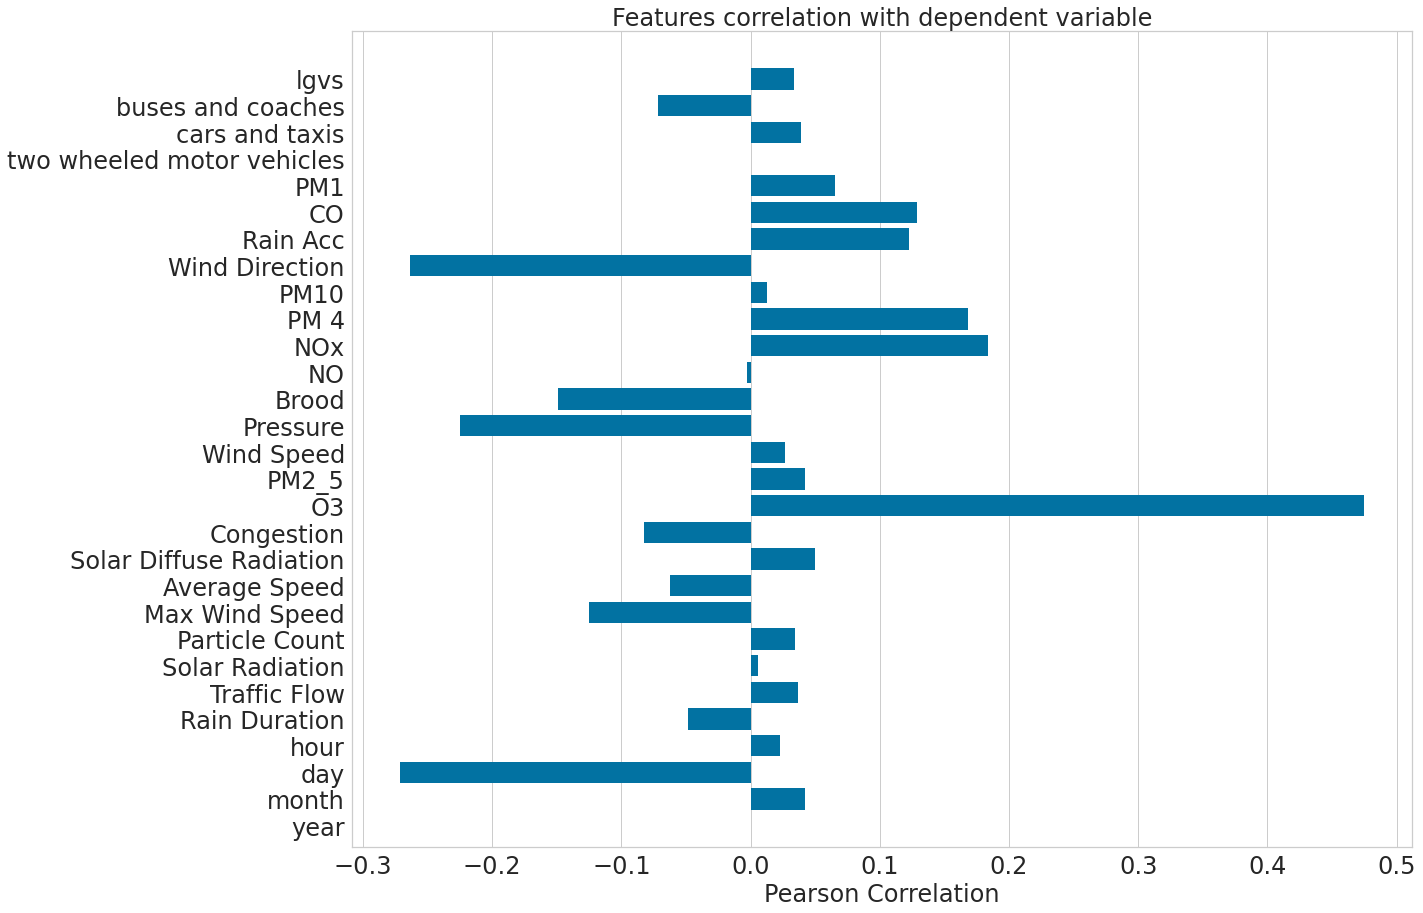

In [ ]:

Ys=DF2018["NO2"].values
Ys_of_train=np.zeros_like(Ys)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4

correlation(DF2018.drop('NO2', axis=1),Ys_of_train)

#results

In [ ]:
Xs_of_train=trainx18.values
Ys=trainy18.values
Ys_of_train=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    Ys_of_train[i]=0
  elif(Ys[i]=='Moderate'):
    Ys_of_train[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    Ys_of_train[i]=2
  elif(Ys[i]=='Unhealthy'):
    Ys_of_train[i]=3
  elif(Ys[i]=='Very unhealthy'):
    Ys_of_train[i]=4


Xs_of_test=testx18.values
Ys=testy18.values
y_test=np.zeros(Ys.shape)
for i in range(len(Ys)):
  if(Ys[i]=='Good'):
    y_test[i]=0
  elif(Ys[i]=='Moderate'):
    y_test[i]=1
  elif(Ys[i]=='Unhealthy for sensitive group'):
    y_test[i]=2
  elif(Ys[i]=='Unhealthy'):
    y_test[i]=3
  elif(Ys[i]=='Very unhealthy'):
    y_test[i]=4


accuracy : 0.9143426294820717
precision : [0.87254902 0.92105263 0.8        0.75       0.96875   ]
recall: [0.94680851 0.90322581 0.72727273 0.57142857 0.9893617 ]


No handles with labels found to put in legend.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


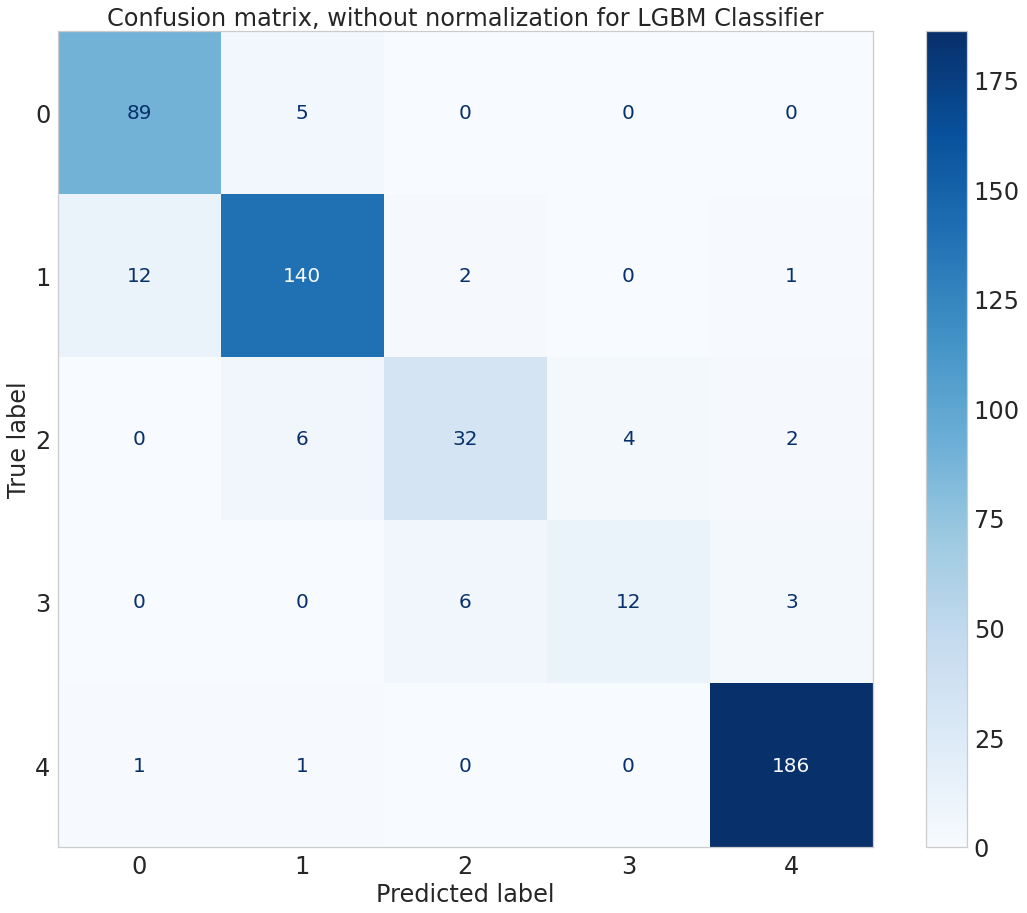

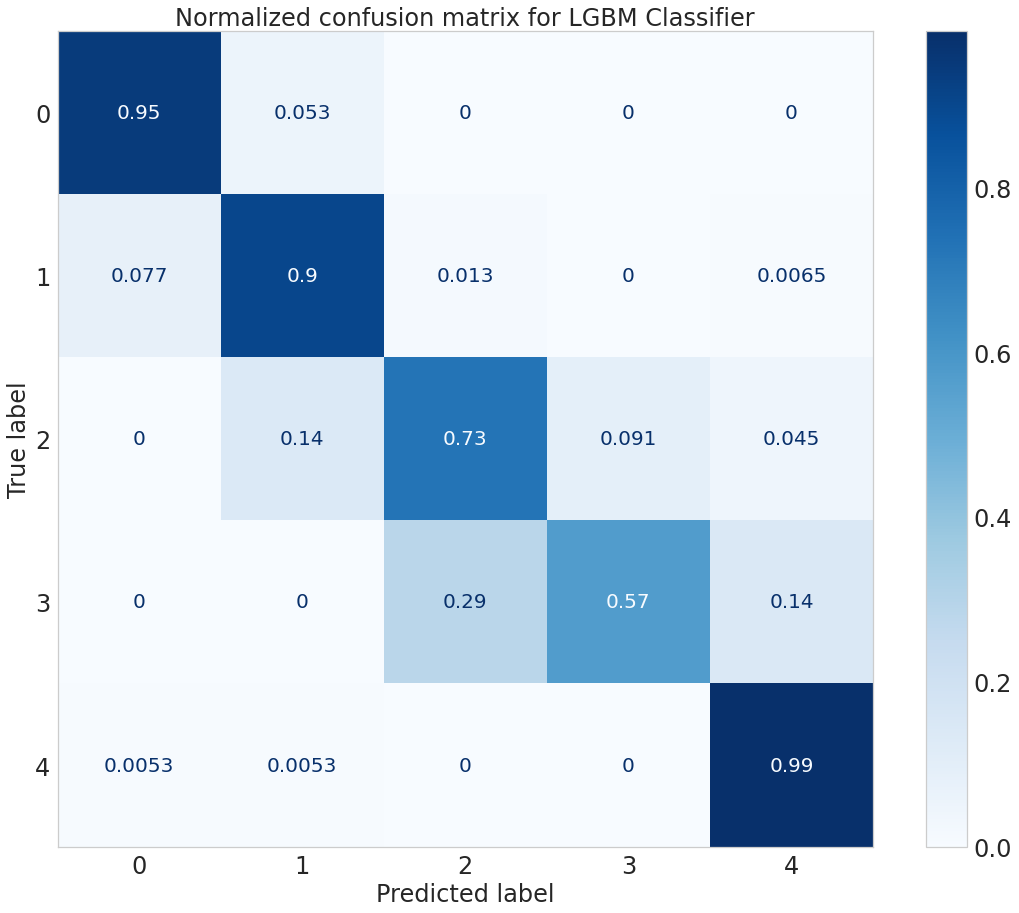

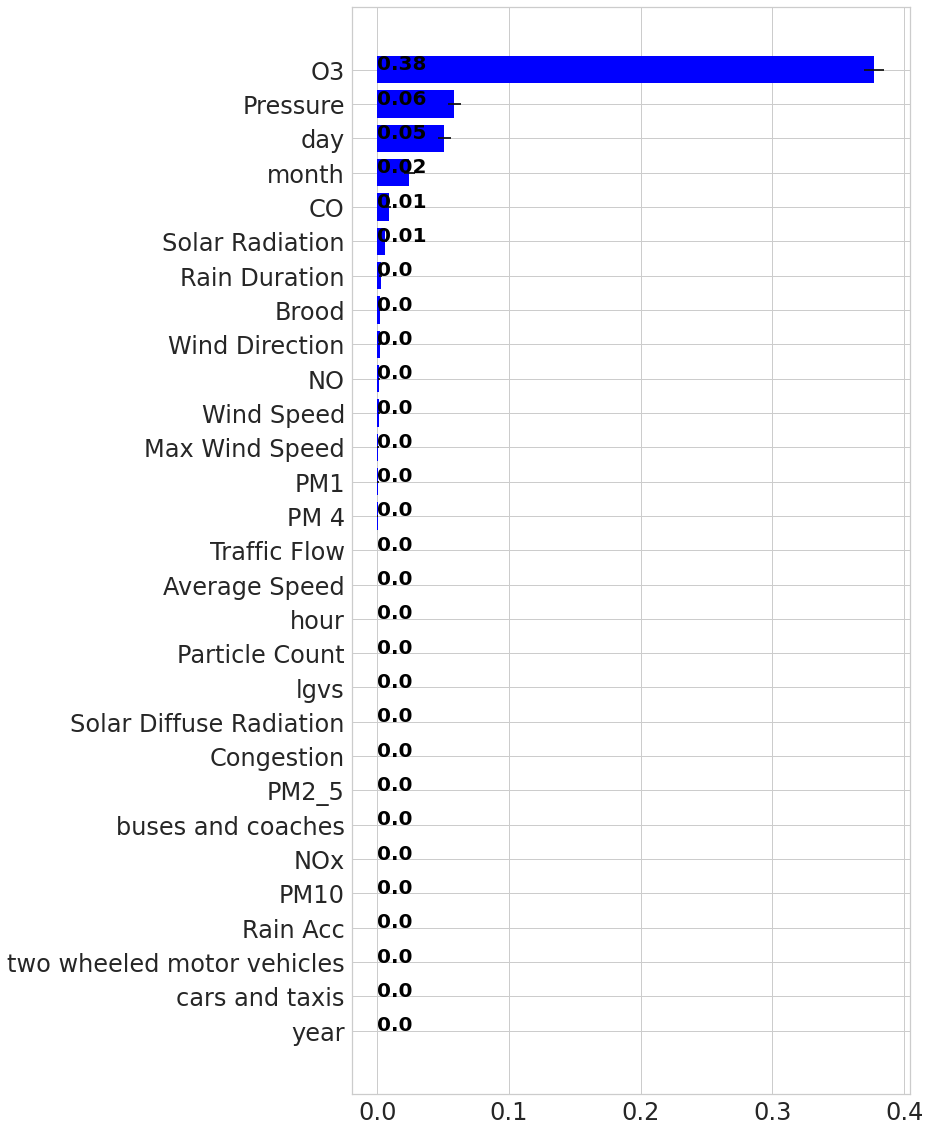

In [ ]:
#LGBm
y_pred = log18.predict(Xs_of_test)
print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

lgbm18_res=[]
lgbm18_res.append(precision_score(y_test, y_pred, average=None))
lgbm18_res.append(recall_score(y_test, y_pred, average=None))
lgbm18_res.append(f1_score(y_test, y_pred, average=None))
lgbm18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    log18, trainx18, Ys_of_train, n_repeats=15)
class_names=["0","1","2","3","4"]
confplt(log18,Xs_of_test,y_test,class_names)
# plot_importance(log18)
# .set_yticklabels("['year', 'month', 'day', 'hour', 'Rain Duration', 'Solar Radiation', 'Particle Count', 'Max Wind Speed', 'Average Speed', 'Solar Diffuse Radiation', 'O3', 'PM2_5', 'Wind Speed', 'Pressure', 'Brood', 'NO', 'NOx', 'PM 4', 'PM10', 'Wind Direction', 'Rain Acc', 'CO', 'PM1', 'two wheeled motor vehicles', 'cars and taxis', 'buses and coaches', 'lgvs']",fontsize=16)
plot_importantes_features(perm_importance_result_train, trainx18.columns)

accuracy : 0.8665338645418327
precision : [0.81818182 0.87012987 0.68181818 0.52631579 0.96774194]
recall: [0.86170213 0.86451613 0.68181818 0.47619048 0.95744681]


No handles with labels found to put in legend.


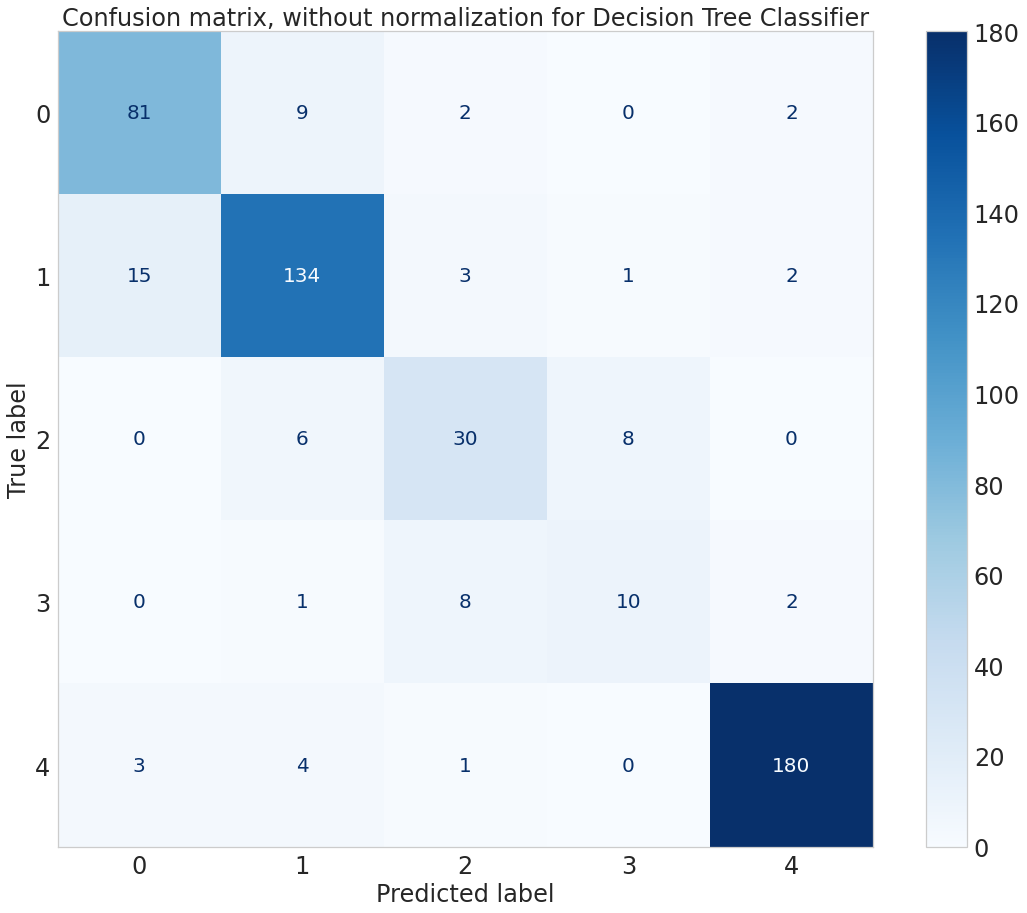

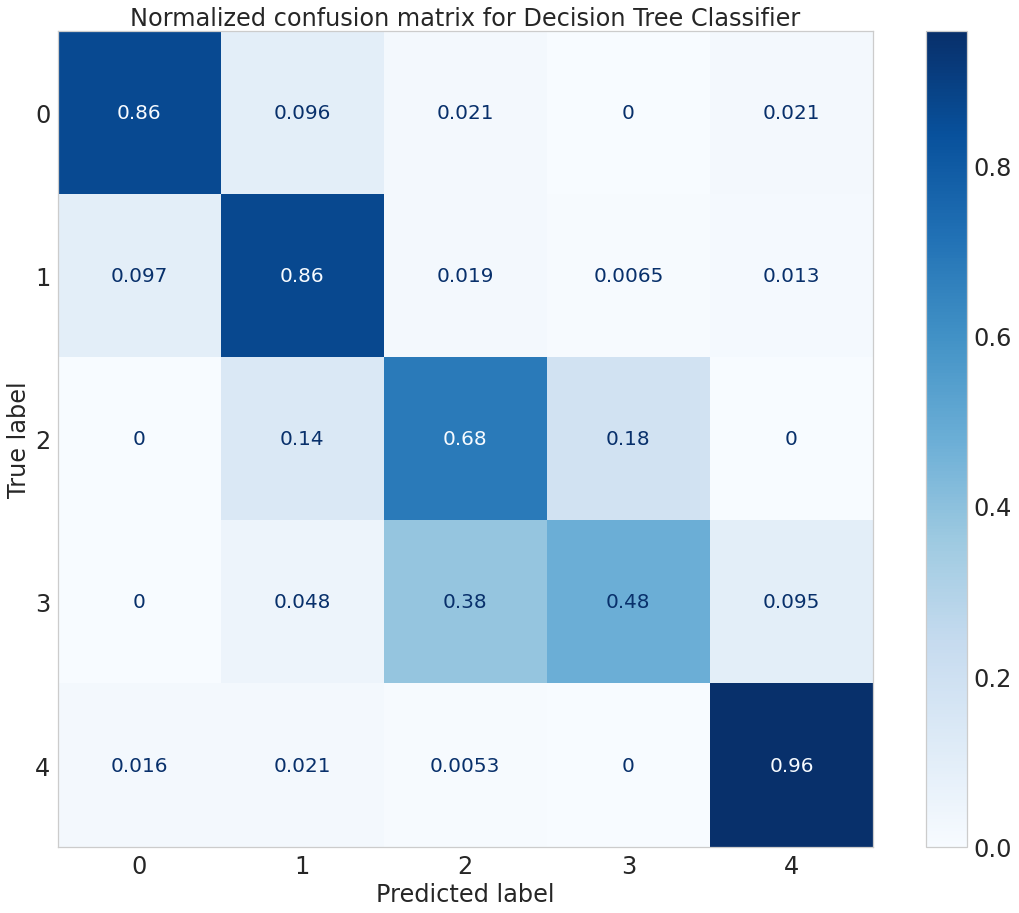

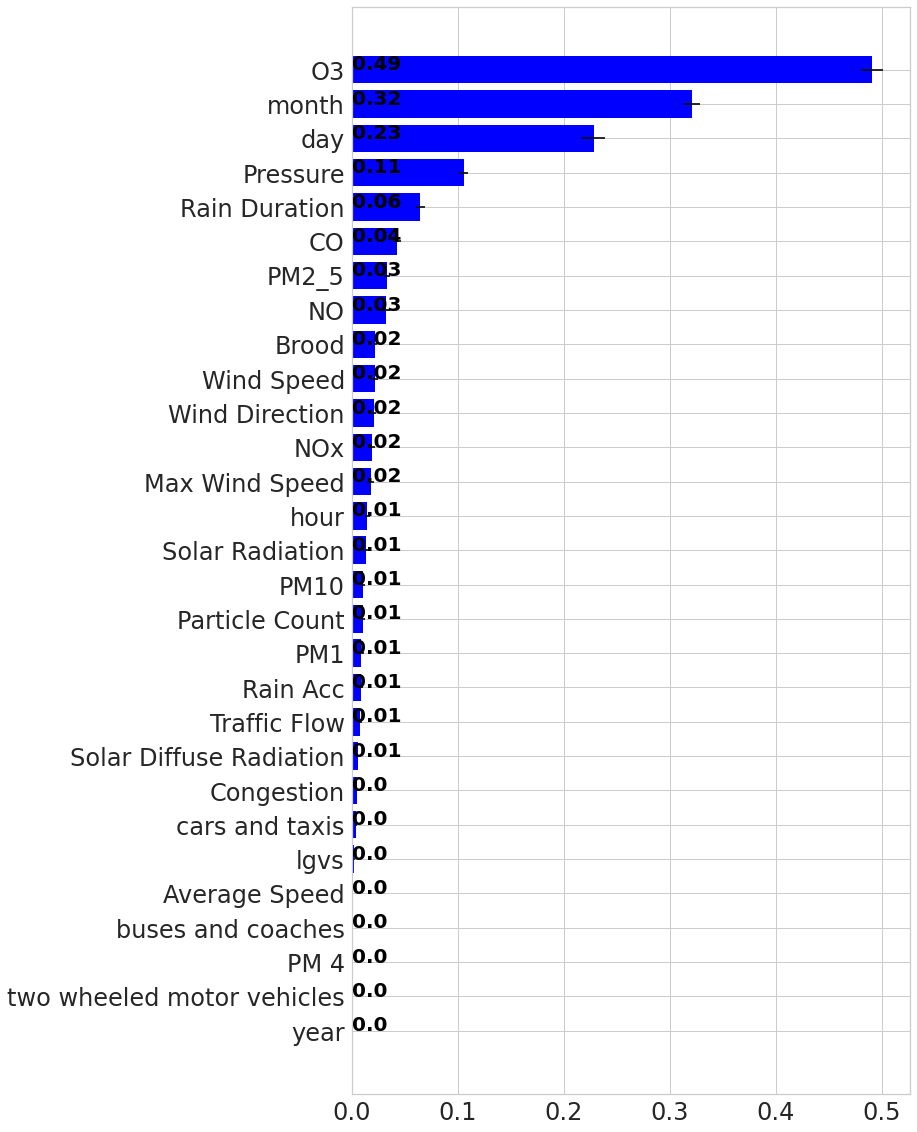

In [ ]:
y_pred = DT18.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

DT18_res=[]
DT18_res.append(precision_score(y_test, y_pred, average=None))
DT18_res.append(recall_score(y_test, y_pred, average=None))
DT18_res.append(f1_score(y_test, y_pred, average=None))
DT18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    DT18, trainx18, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(DT18,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx18.columns)

accuracy : 0.8047808764940239
precision : [0.69158879 0.76047904 0.68292683 0.66666667 0.95428571]
recall: [0.78723404 0.81935484 0.63636364 0.38095238 0.88829787]


No handles with labels found to put in legend.


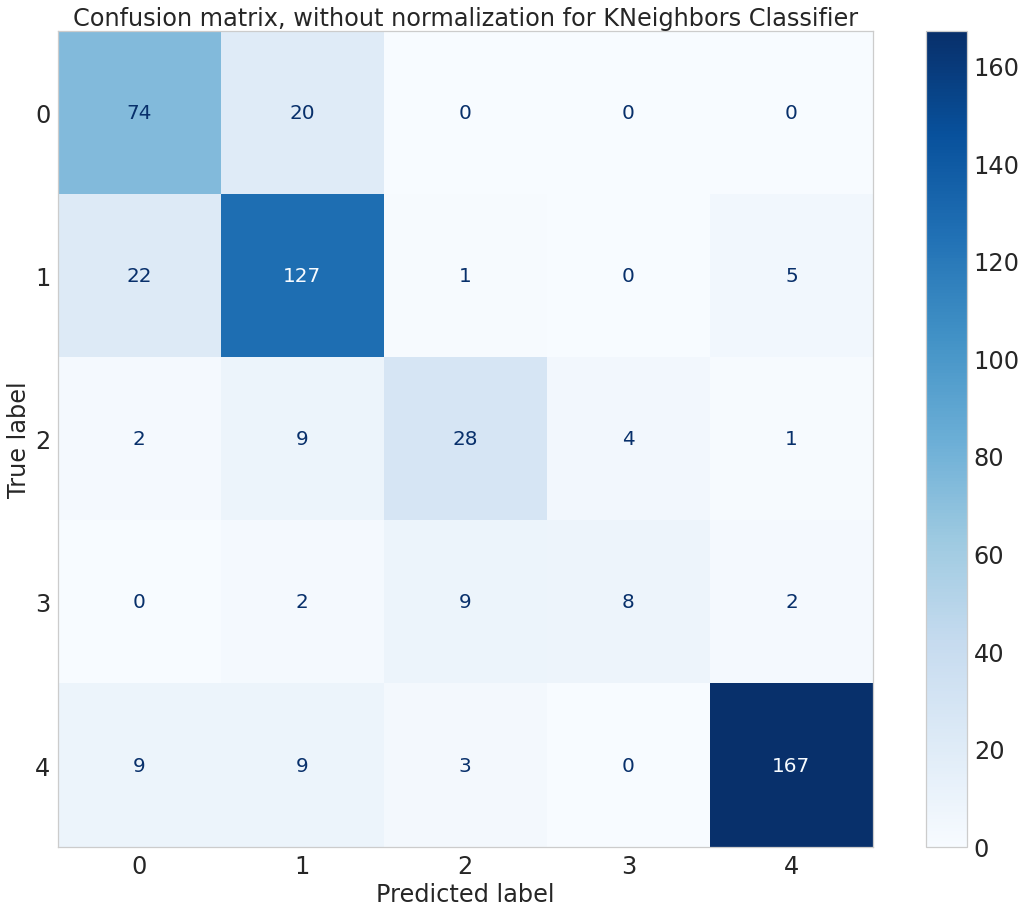

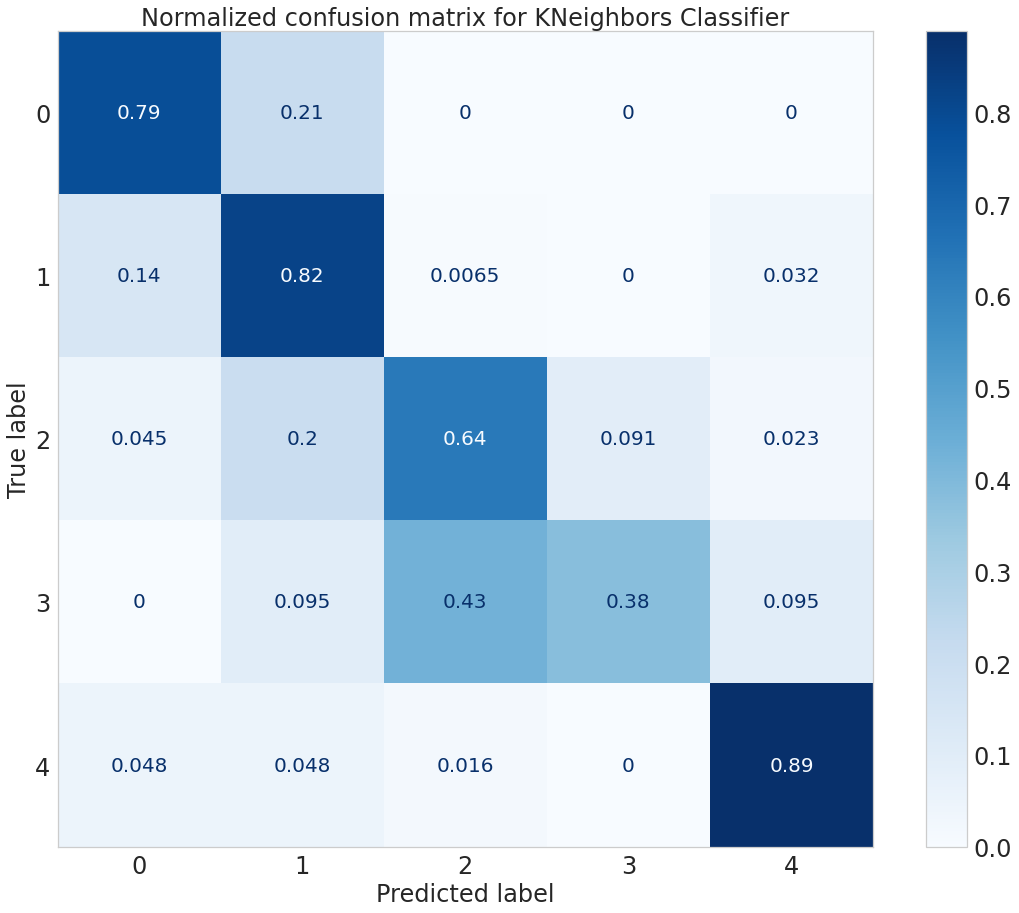

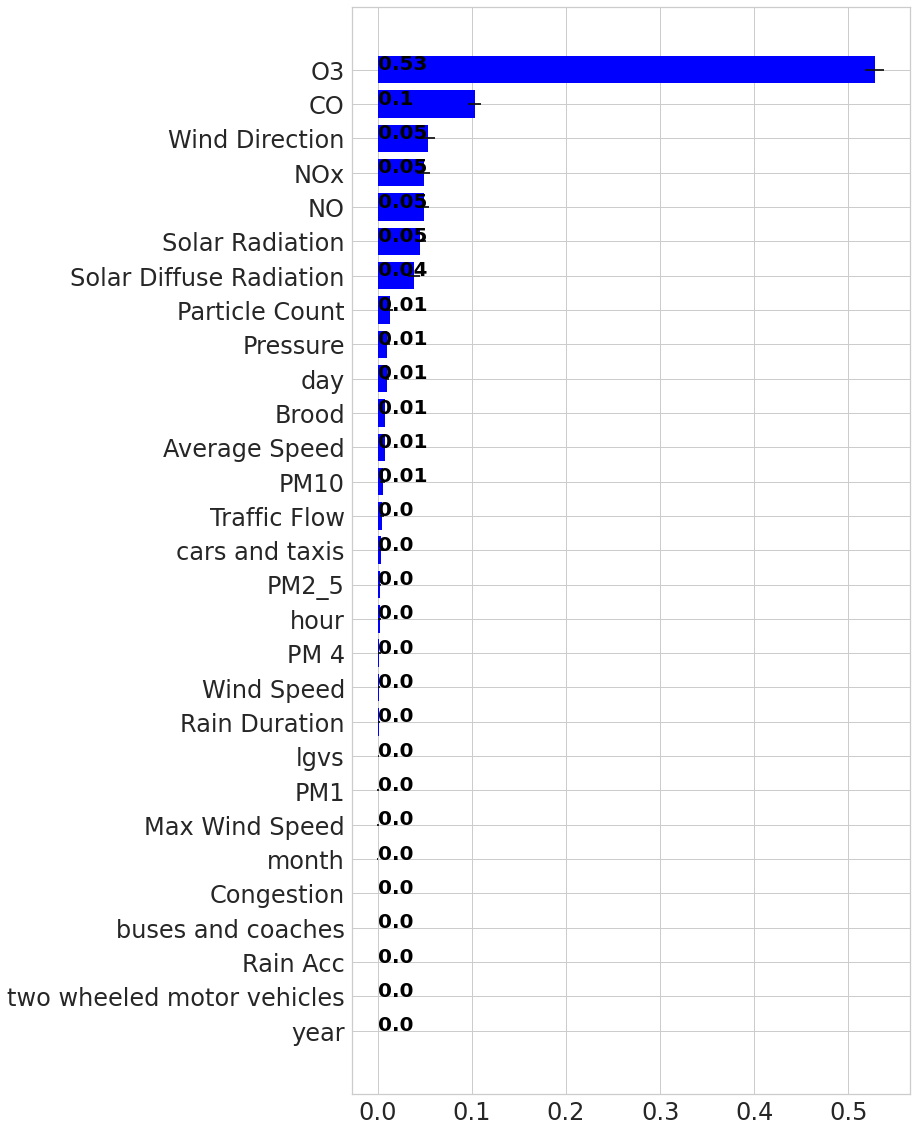

In [ ]:
#KN
y_pred = KN18.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

KN18_res=[]
KN18_res.append(precision_score(y_test, y_pred, average=None))
KN18_res.append(recall_score(y_test, y_pred, average=None))
KN18_res.append(f1_score(y_test, y_pred, average=None))
KN18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    KN18, trainx18, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(KN18,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx18.columns)

accuracy : 0.896414342629482
precision : [0.84848485 0.875      0.79487179 0.78571429 0.96842105]
recall: [0.89361702 0.90322581 0.70454545 0.52380952 0.9787234 ]


No handles with labels found to put in legend.


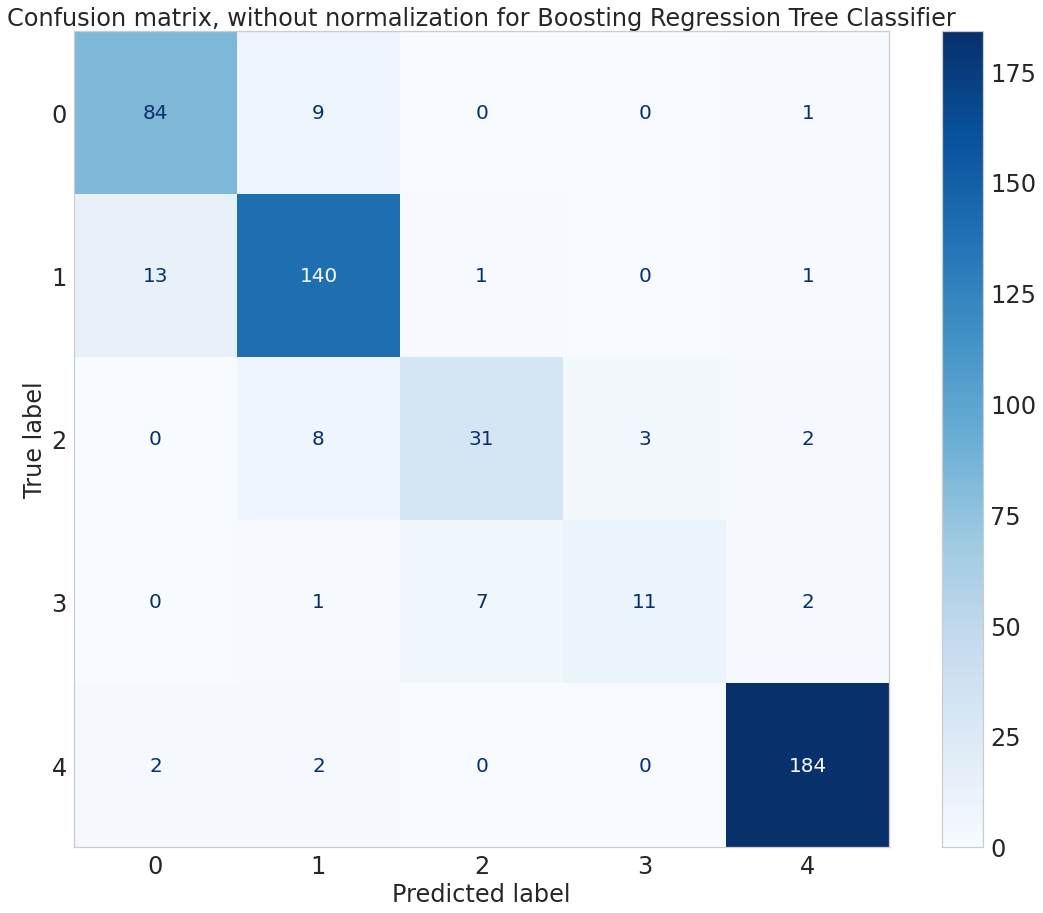

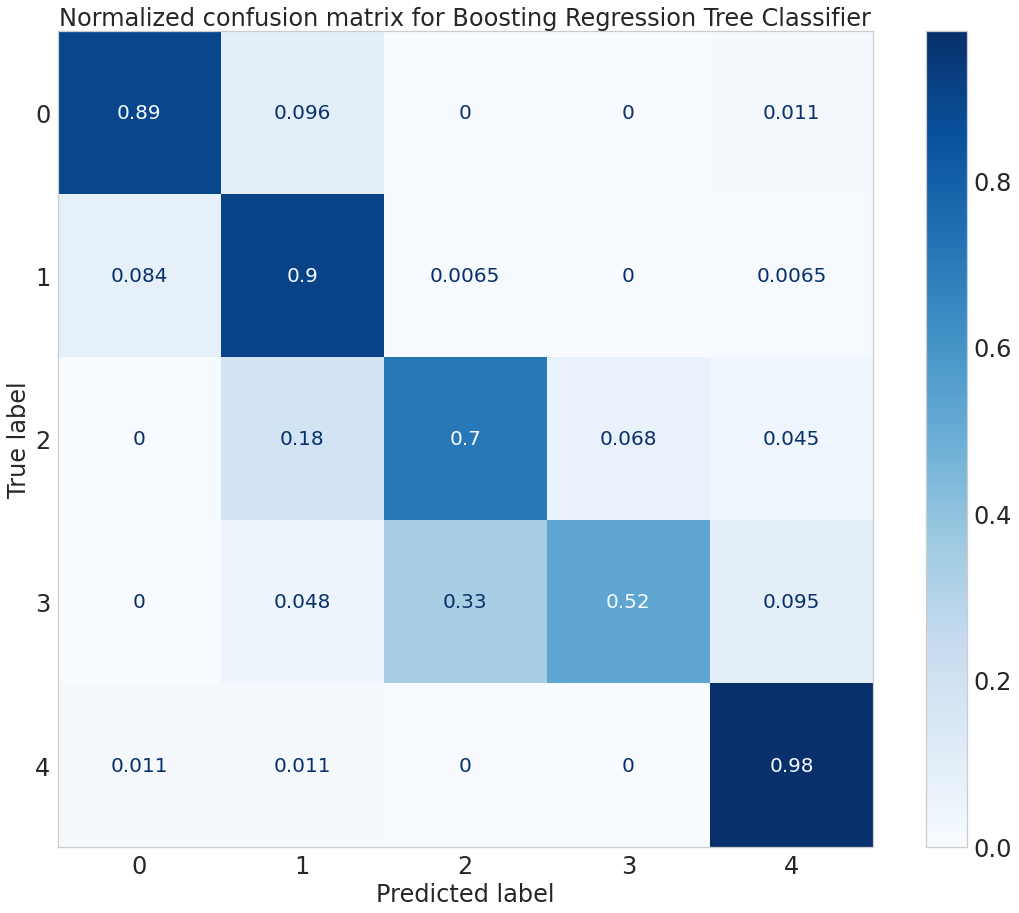

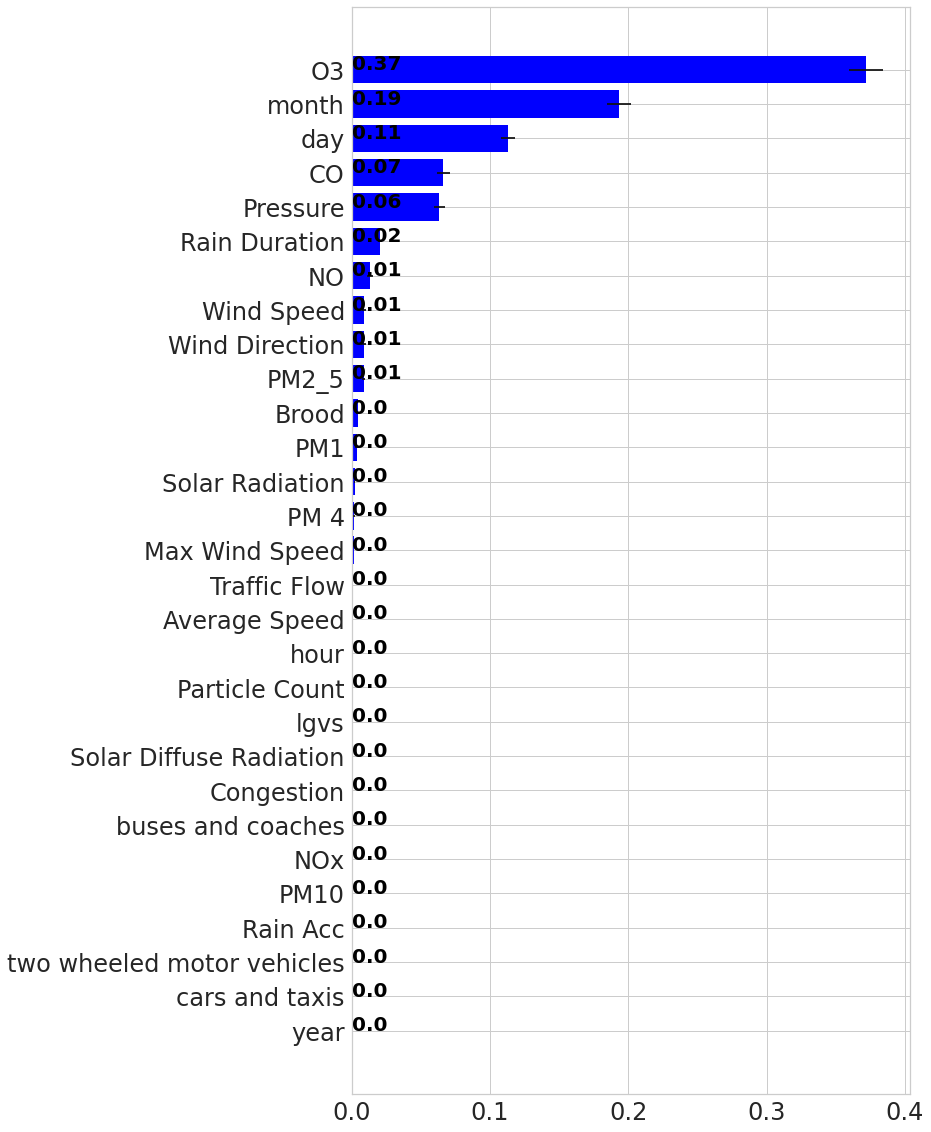

In [ ]:
#BRT18
y_pred = BRT18.predict(Xs_of_test)

print("accuracy :", accuracy_score(y_pred, y_test))
print("precision :",precision_score(y_test, y_pred, average=None))
print("recall:",recall_score(y_test, y_pred, average=None))

BRT18_res=[]
BRT18_res.append(precision_score(y_test, y_pred, average=None))
BRT18_res.append(recall_score(y_test, y_pred, average=None))
BRT18_res.append(f1_score(y_test, y_pred, average=None))
BRT18_res.append(accuracy_score(y_pred, y_test))
import warnings
warnings.filterwarnings('ignore')
perm_importance_result_train = permutation_importance(
    BRT18, trainx18, Ys_of_train, n_repeats=15)

class_names=["0","1","2","3","4"]
confplt(BRT18,Xs_of_test,y_test,class_names)
plot_importantes_features(perm_importance_result_train, trainx18.columns)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


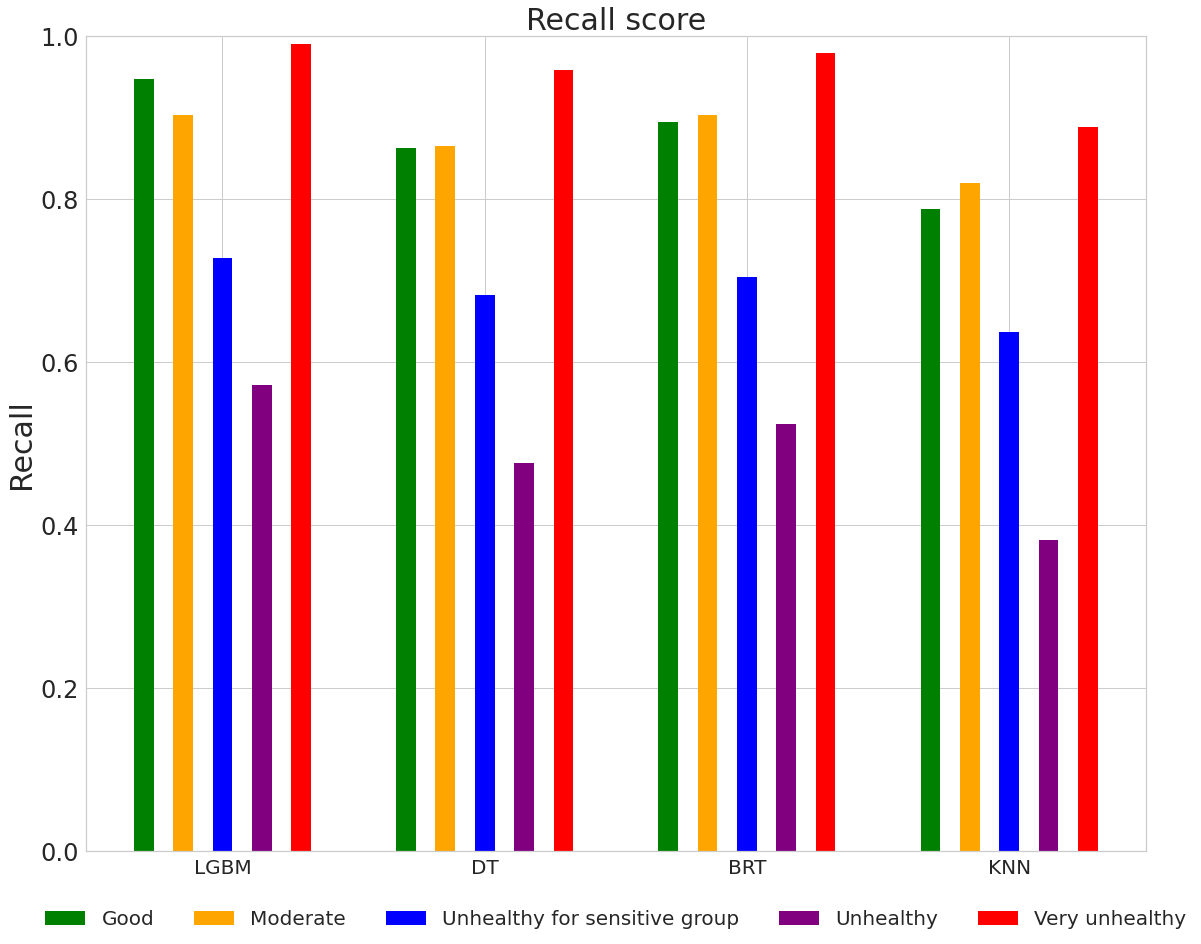

In [ ]:
xaxis = [2,4,6,8]
xaxis_dec2 = [x-0.60 for x in xaxis]
xaxis_dec = [x-0.30 for x in xaxis]
xaxis_zer = [x for x in xaxis]
xaxis_inc = [x+0.30 for x in xaxis]
xaxis_inc2 = [x+0.60 for x in xaxis]
LABELS = ["LGBM", "DT", "BRT", 'KNN']
# xaxis = [1,2,3,4]
# xaxis_dec = [x-0.15 for x in xaxis]
# xaxis_inc = [x+0.15 for x in xaxis]
# LABELS = ["LGBM", "DT", "BRT", 'KNN']





recall_lgbm=lgbm18_res[1]
recall_DT=DT18_res[1]
recall_BRT=BRT18_res[1]
recall_KNN=KN18_res[1]
rec0 = [recall_lgbm[0],recall_DT[0],recall_BRT[0],recall_KNN[0]]
rec1 = [recall_lgbm[1],recall_DT[1],recall_BRT[1],recall_KNN[1]]
rec2 = [recall_lgbm[2],recall_DT[2],recall_BRT[2],recall_KNN[2]]
rec3 = [recall_lgbm[3],recall_DT[3],recall_BRT[3],recall_KNN[3]]
rec4 = [recall_lgbm[4],recall_DT[4],recall_BRT[4],recall_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec2, rec0, width=0.15,color='green',align='center', label = 'Good')
ax.bar(xaxis_dec, rec1, width=0.15,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_zer, rec2, width=0.15,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.15,color='purple',align='center', label = 'Unhealthy')
ax.bar(xaxis_inc2, rec4, width=0.15,color='red',align='center', label = 'Very unhealthy')

# ax = plt.subplot(111)
# ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
# ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
# ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
# ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
# ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')




ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS, fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('Recall',fontsize=30)
plt.title("Recall score",fontsize=30)
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


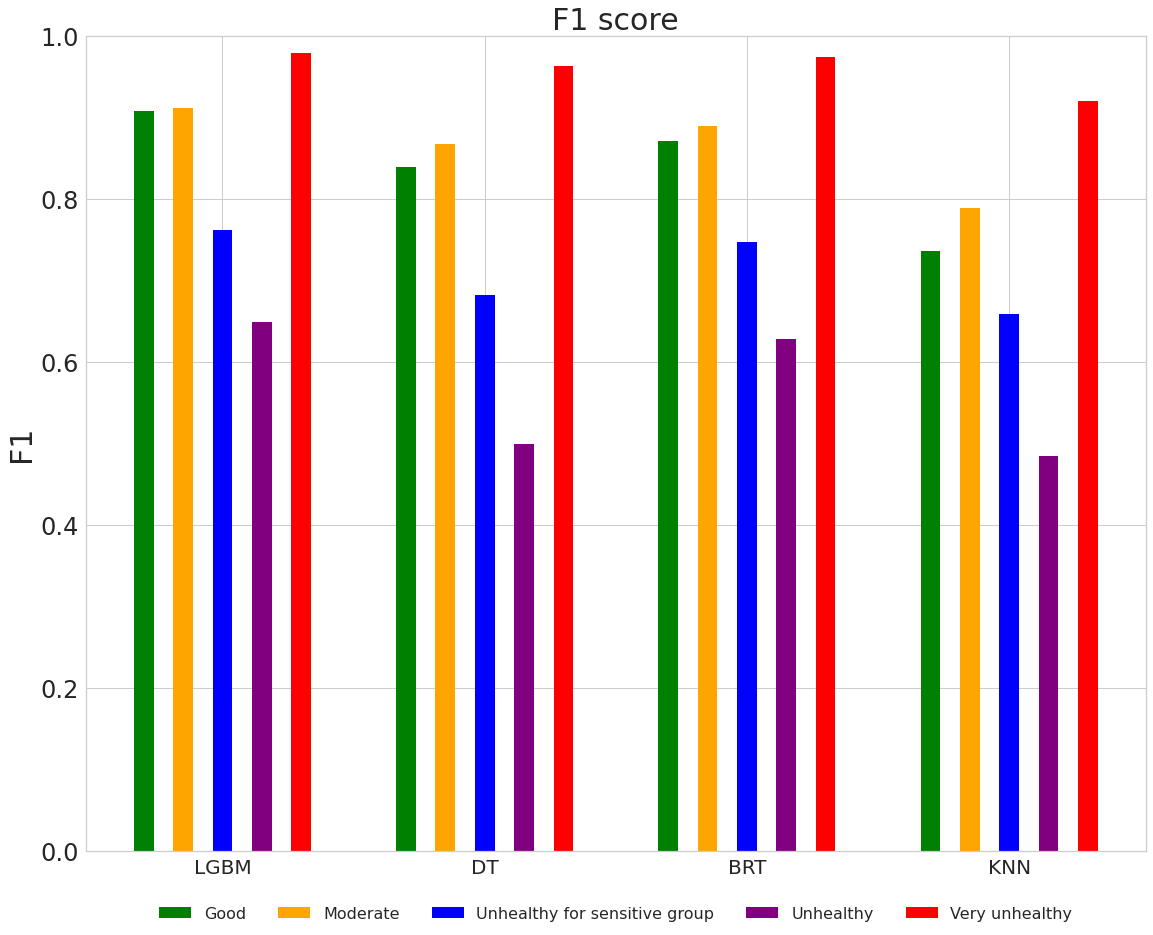

In [ ]:
xaxis = [2,4,6,8]
xaxis_dec2 = [x-0.60 for x in xaxis]
xaxis_dec = [x-0.30 for x in xaxis]
xaxis_zer = [x for x in xaxis]
xaxis_inc = [x+0.30 for x in xaxis]
xaxis_inc2 = [x+0.60 for x in xaxis]
LABELS = ["LGBM", "DT", "BRT", 'KNN']
# xaxis = [1,2,3,4]
# xaxis_dec = [x-0.15 for x in xaxis]
# xaxis_inc = [x+0.15 for x in xaxis]
# LABELS = ["LGBM", "DT", "BRT", 'KNN']


f1_lgbm=lgbm18_res[2]
f1_DT=DT18_res[2]
f1_BRT=BRT18_res[2]
f1_KNN=KN18_res[2]
rec0 = [f1_lgbm[0],f1_DT[0],f1_BRT[0],f1_KNN[0]]
rec1 = [f1_lgbm[1],f1_DT[1],f1_BRT[1],f1_KNN[1]]
rec2 = [f1_lgbm[2],f1_DT[2],f1_BRT[2],f1_KNN[2]]
rec3 = [f1_lgbm[3],f1_DT[3],f1_BRT[3],f1_KNN[3]]
rec4 = [f1_lgbm[4],f1_DT[4],f1_BRT[4],f1_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec2, rec0, width=0.15,color='green',align='center', label = 'Good')
ax.bar(xaxis_dec, rec1, width=0.15,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_zer, rec2, width=0.15,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.15,color='purple',align='center', label = 'Unhealthy')
ax.bar(xaxis_inc2, rec4, width=0.15,color='red',align='center', label = 'Very unhealthy')

# ax = plt.subplot(111)
# ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
# ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
# ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
# ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
# ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')


ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS,fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,fontsize=16)
plt.ylabel('F1',fontsize=30)
plt.title("F1 score",fontsize=30)
plt.show()


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


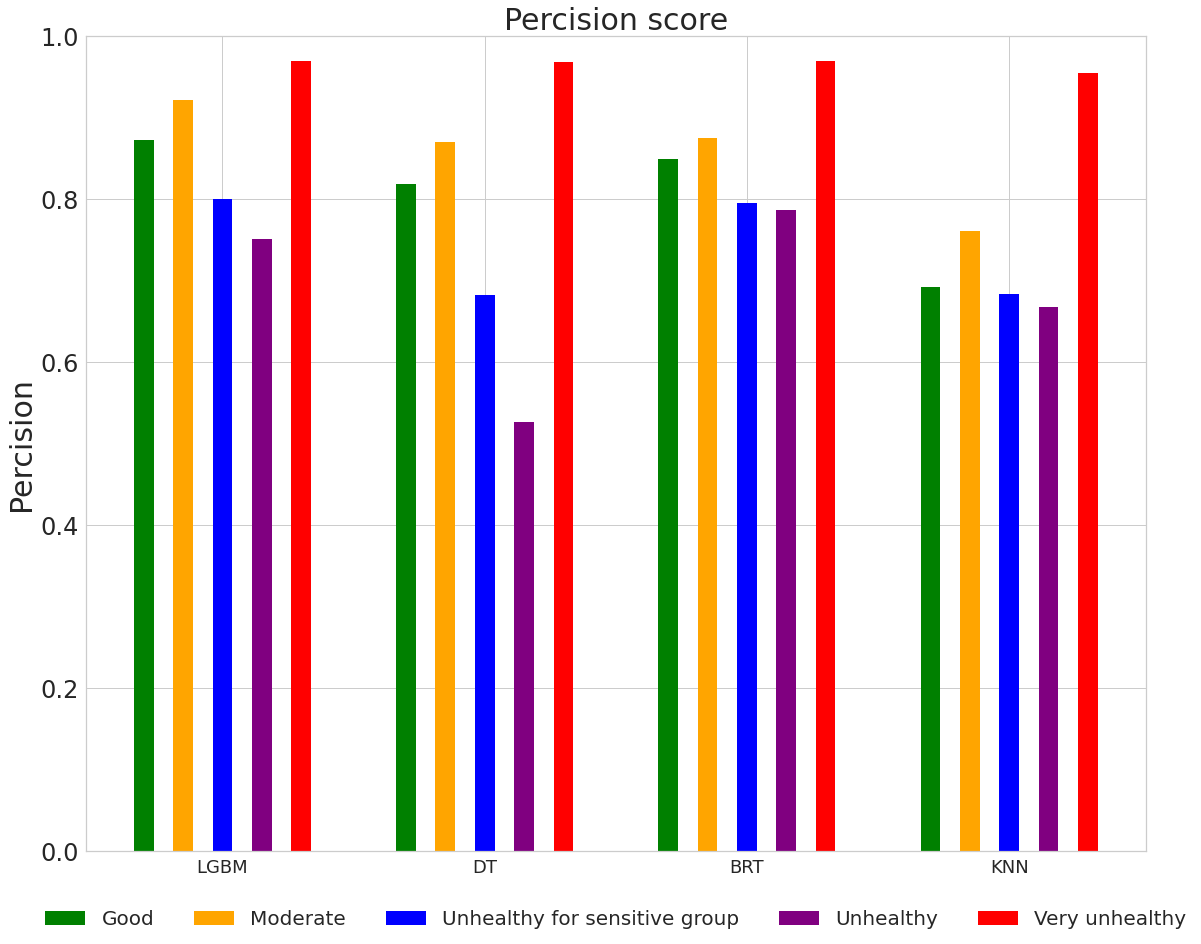

In [ ]:
xaxis = [2,4,6,8]
xaxis_dec2 = [x-0.60 for x in xaxis]
xaxis_dec = [x-0.30 for x in xaxis]
xaxis_zer = [x for x in xaxis]
xaxis_inc = [x+0.30 for x in xaxis]
xaxis_inc2 = [x+0.60 for x in xaxis]
LABELS = ["LGBM", "DT", "BRT", 'KNN']
# xaxis = [1,2,3,4]
# xaxis_dec = [x-0.15 for x in xaxis]
# xaxis_inc = [x+0.15 for x in xaxis]
# LABELS = ["LGBM", "DT", "BRT", 'KNN']


precision_lgbm=lgbm18_res[0]
precision_DT=DT18_res[0]
precision_BRT=BRT18_res[0]
precision_KNN=KN18_res[0]
rec0 = [precision_lgbm[0],precision_DT[0],precision_BRT[0],precision_KNN[0]]
rec1 = [precision_lgbm[1],precision_DT[1],precision_BRT[1],precision_KNN[1]]
rec2 = [precision_lgbm[2],precision_DT[2],precision_BRT[2],precision_KNN[2]]
rec3 = [precision_lgbm[3],precision_DT[3],precision_BRT[3],precision_KNN[3]]
rec4 = [precision_lgbm[4],precision_DT[4],precision_BRT[4],precision_KNN[4]]



ax = plt.subplot(111)
ax.bar(xaxis_dec2, rec0, width=0.15,color='green',align='center', label = 'Good')
ax.bar(xaxis_dec, rec1, width=0.15,color='orange',align='center', label = 'Moderate')
ax.bar(xaxis_zer, rec2, width=0.15,color='blue',align='center', label = 'Unhealthy for sensitive group')
ax.bar(xaxis_inc, rec3, width=0.15,color='purple',align='center', label = 'Unhealthy')
ax.bar(xaxis_inc2, rec4, width=0.15,color='red',align='center', label = 'Very unhealthy')

# ax = plt.subplot(111)
# ax.bar(xaxis_dec, rec0, width=0.2,color='green',align='center', label = 'Good')
# ax.bar(xaxis_inc, rec1, width=0.2,color='orange',align='center', label = 'Moderate')
# ax.bar(xaxis_dec, rec2, width=0.2,color='blue',align='center', label = 'Unhealthy for sensitive group')
# ax.bar(xaxis_inc, rec3, width=0.2,color='purple',align='center', label = 'unhealthy')
# ax.bar(xaxis_inc, rec4, width=0.2,color='red',align='center', label = 'Very unhealthy')


ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS, fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.ylabel('Percision', fontsize=30)
plt.title("Percision score", fontsize=30)
plt.show()

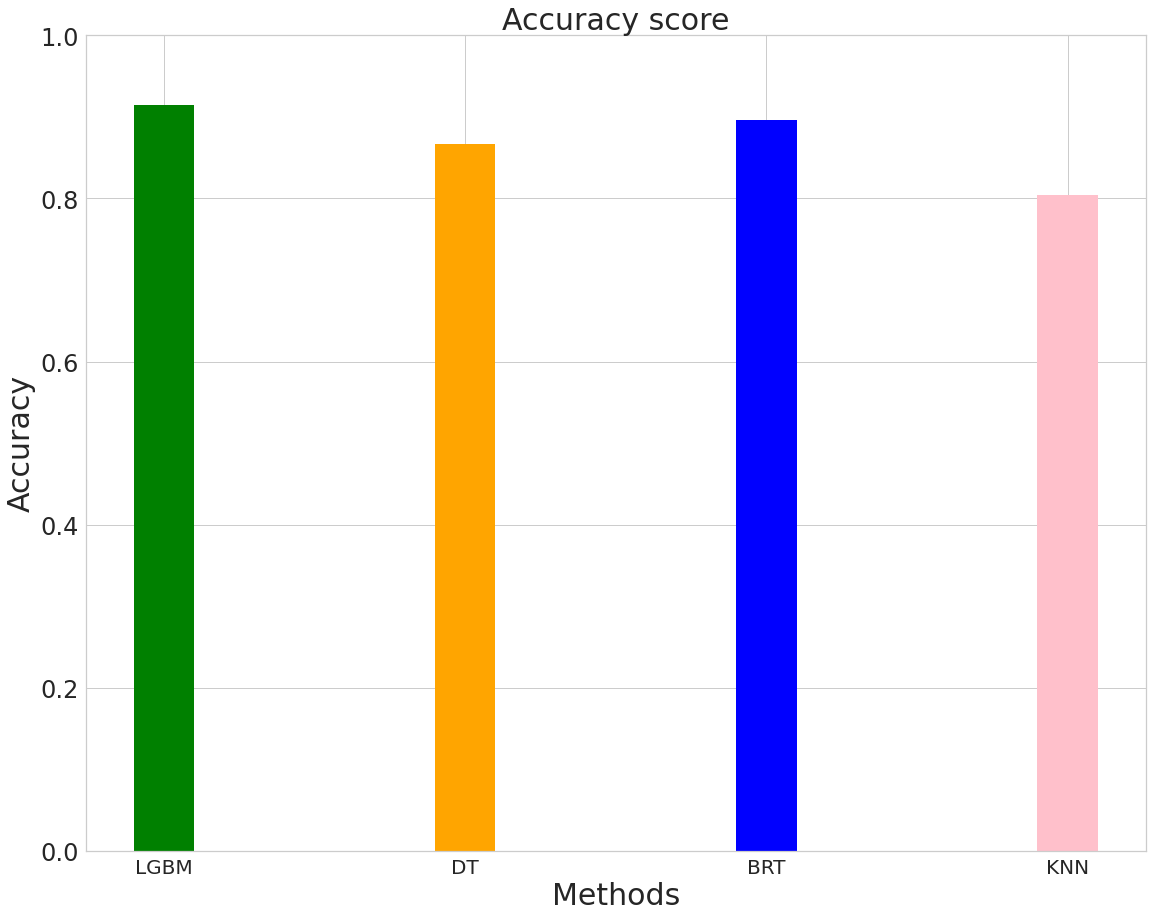

In [ ]:
xaxis = [1,2,3,4]
xaxis_dec = [x for x in xaxis]
xaxis_inc = [x for x in xaxis]
LABELS = ["LGBM", "DT", "BRT", 'KNN']

acc_lgbm=lgbm18_res[3]
acc_DT=DT18_res[3]
acc_BRT=BRT18_res[3]
acc_KNN=KN18_res[3]
rec0 = [acc_lgbm,acc_DT,acc_BRT,acc_KNN]


ax = plt.subplot(111)
ax.bar(xaxis_dec, rec0, width=0.2,color=['green','orange','blue','pink'],align='center')

ax.set_ylim((0, 1))
plt.xticks(xaxis, LABELS, fontsize=20)
plt.xlabel('Methods', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.title("Accuracy score", fontsize=30)
plt.show()
